# Querying ATL08 Entwine Point Tiles

This notebook provides sample code for querying and visualizing the Entwine Point Tiles Store for ATL08 V003.

[Entwine Point Tiles (EPT)](https://entwine.io/entwine-point-tile.html) are a new "cloud-optimized" storage format for large point cloud data.

Warning: this notebook requires a working PDAL installation

See https://pdal.io/download.html#download for how to install pdal

In [ ]:
#!pip install folium geopandas gpstime pyproj

In [ ]:
import json
import os
import datetime

import gpstime
from pyproj import CRS, Transformer
import folium
import geopandas as gpd
#import pdal

from maap.maap import MAAP
maap = MAAP(maap_host='api.ops.maap-project.org')

### Variables

The data columns in the EPT data correspond to the following ATL08 variables:

* Z - `gtx/land_segments/dem_h`
* ElevationLow - `gtx/land_segments/terrain/h_te_best_fit`
* HeightAboveGround - `gtx/land_segments/canopy/h_canopy`
* OriginId - `OriginId` is a numeric reference to an origin file, and references for all `OriginId`s can be found in `ept-sources/list.json`. The origin file is a las file passed as `origin` to the pdal EPT reader.
* GpsTime - `GpsTime` is the addition of the value of the HDF field `/ancillary_data/atlas_sdp_gps_epoch` (`1198800018`) and `gtx/land_segments/delta_time`.

Read more about those variables in the [ATL08 Data Dictionary](https://nsidc.org/sites/nsidc.org/files/technical-references/ICESat2_ATL08_data_dict_v003.pdf).

## Locate EPT Data

In [14]:
##Get the ept store url from a CMR search
atl08_global_ept = maap.searchGranule(concept_id="G1200352824-NASA_MAAP", limit=10)

## Define the global EPT source for our data queries
ept_store = atl08_global_ept[0].getDownloadUrl()
print(ept_store)

s3://nasa-maap-data-store/file-staging/nasa-map/ATL08_ARD-beta___001/global/ept/ept.json


## PDAL Pipelines

PDAL pipelines can be used for a large set of data querying functionality, such as filtering data variables to be within a given range. Read more about different PDAL pipeline options here: https://pdal.io/pipeline.html

In [2]:


## Define a function for running a pdal pipeline and returning the filename as output
def run_pipeline(pipeline_def, output_file):
    pipeline_def[-1]["filename"] = output_file
    pipeline_json =  json.dumps(pipeline_def)
    pipeline = pdal.Pipeline(pipeline_json)

    # remove the output file before building a new one
    if os.path.exists(output_file):
        os.remove(output_file)

    count = pipeline.execute()
    data = open(output_file, 'r').read()
    data = data.replace("[,{", "[{").replace("}{", "},{")
    open(output_file, 'w').write(data)
    return output_file

### Query by Granule using OriginId

To query for data from a particular granule, we can use the filename prefix to query the EPT store by `origin`.

In [3]:
granule_id = "ATL08_20181026111023_04250106_003_01"
output_geojson = f"{granule_id}-subset.geojson"

pipeline_def = [
    {
        "type": "readers.ept",
        "filename": ept_store,
        "origin": f"{granule_id}.las"
    },
    {
        "type": "filters.reprojection",
        "out_srs":"EPSG:4326"
    },
    {
        "type" : "writers.text",
        "format": "geojson",
        "write_header": True
    }
]

run_pipeline(pipeline_def, output_geojson)

'ATL08_20181026111023_04250106_003_01-subset.geojson'

### Query by Bounding Box

To query for data for a bounding box, we first have to convert coordinates to the CRS of the EPT store (EPSG:3857).

In [4]:
xmin, xmax = 10.1299,10.13
ymin, ymax = -0.0001,0
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
xmin, ymax = transformer.transform(xmin, ymax)
xmax, ymin = transformer.transform(xmax, ymin)
pdal_aoi_bounds = f"([{xmin}, {xmax}], [{ymin}, {ymax}])"
pdal_aoi_bounds

'([1127655.3097867817, 1127666.4417358614], [-11.131949079964679, 0.0])'

In [ ]:
pipeline_def = [
    {
        "type": "readers.ept",
        "filename": ept_store
    },
    {
        "type":"filters.crop",
        "bounds": pdal_aoi_bounds
    },
    {
        "type" : "writers.text",
        "format": "geojson",
        "write_header": True
    }
]

run_pipeline(pipeline_def, "spatial-subset.geojson")

### Convert GpsTime to Datetime

As described above, the data contains the field `GpsTime`:

>GPS Time (GPST) is a continuous time scale (no leap seconds) defined by the GPS Control segment on the basis of a set of atomic clocks at the Monitor Stations and onboard the satellites. It starts at 0h UTC (midnight) of January 5th to 6th 1980.

[Source gssc.esa.int](https://gssc.esa.int/navipedia/index.php/Time_References_in_GNSS#:~:text=GPS%20Time%20(GPST)%20is%20a,5th%20to%206th%201980%20(6.&text=0).)

In [12]:
timestamp = gpstime.gps2unix(1224587557.969)
datetime.datetime.fromtimestamp(timestamp)

datetime.datetime(2018, 10, 26, 11, 12, 19, 969000)

### Working with the results

Below are a number of examples of how to work with the geojson output from the example pipelines above.

#### Reading into a data frame

In [17]:
df = gpd.read_file(output_geojson)
gdf = gpd.GeoDataFrame(df, crs='epsg:4326')
gdf

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,...,GpsTime,Red,Green,Blue,ScanChannel,ClassFlags,HeightAboveGround,OffsetTime,OriginId,geometry
0,-120.400,52.990,1798.850,0.000,1.000,1.000,0.000,0.000,0.000,0.000,...,1224587544.786,241.000,243.000,220.000,0.000,0.000,11.810,25787527.000,1656.000,POINT Z (-120.40000 52.99000 1798.85000)
1,-120.380,52.790,1898.400,0.000,1.000,1.000,0.000,0.000,0.000,0.000,...,1224587547.798,253.000,241.000,216.000,0.000,0.000,9.477,25787530.000,1656.000,POINT Z (-120.38000 52.79000 1898.40000)
2,-120.420,52.530,1566.290,0.000,1.000,1.000,0.000,0.000,0.000,0.000,...,1224587552.004,192.000,221.000,206.000,0.000,0.000,20.610,25787534.000,1656.000,POINT Z (-120.42000 52.53000 1566.29000)
3,-121.790,43.670,1304.740,0.000,1.000,1.000,0.000,0.000,0.000,0.000,...,1224587691.200,117.000,172.000,166.000,0.000,0.000,11.290,25787673.000,1656.000,POINT Z (-121.79000 43.67000 1304.74000)
4,-120.430,53.120,1737.410,0.000,1.000,1.000,0.000,0.000,0.000,0.000,...,1224587542.720,232.000,240.000,220.000,0.000,0.000,4.658,25787525.000,1656.000,POINT Z (-120.43000 53.12000 1737.41000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5529,-120.540,52.110,2020.160,0.000,1.000,1.000,0.000,0.000,0.000,0.000,...,1224587558.603,255.000,231.000,203.000,0.000,0.000,9.739,25787541.000,1656.000,POINT Z (-120.54000 52.11000 2020.16000)
5530,-120.540,52.110,2042.320,0.000,1.000,1.000,0.000,0.000,0.000,0.000,...,1224587558.617,255.000,228.000,199.000,0.000,0.000,9.021,25787541.000,1656.000,POINT Z (-120.54000 52.11000 2042.32000)
5531,-120.540,52.110,2069.380,0.000,1.000,1.000,0.000,0.000,0.000,0.000,...,1224587558.631,255.000,225.000,195.000,0.000,0.000,9.126,25787541.000,1656.000,POINT Z (-120.54000 52.11000 2069.38000)
5532,-120.540,52.110,2103.160,0.000,1.000,1.000,0.000,0.000,0.000,0.000,...,1224587558.645,255.000,219.000,188.000,0.000,0.000,13.731,25787541.000,1656.000,POINT Z (-120.54000 52.11000 2103.16000)


### Visualization

We can use folium to map the data.

In [9]:
import warnings
warnings.filterwarnings('ignore')

m = folium.Map(
    location=[gdf.centroid[0].y, gdf.centroid[0].x],
    zoom_start=10,
    tiles='Stamen Terrain'
)


folium.GeoJson(
    gdf,
    name = "geojson"
).add_to(m)

#m

### Plotting

Finally, we can plot the data values

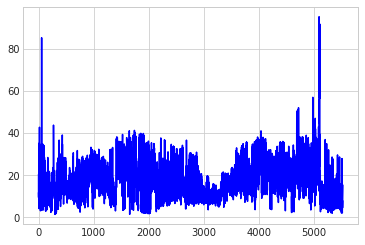

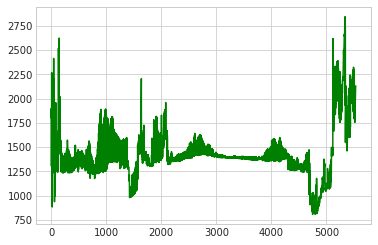

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

fig = plt.figure()
ax = plt.axes()
x = range(gdf.shape[0])

plt.plot(x, gdf.HeightAboveGround.astype(float), color='blue')

fig = plt.figure()
ax = plt.axes()
#plt.plot(x, gdf.ElevationLow.astype(float), color='red')
plt.plot(x, gdf.Z.astype(float), color='green')